In [1]:
"""Importing all necessary libraries for data manipulation, visualization, preprocessing, model building, and evaluation"""

import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For advanced data visualization

import xgboost as xgb  # XGBoost library for gradient boosting
from xgboost import XGBClassifier  # XGBoost's classifier model

from sklearn.preprocessing import StandardScaler  # To standardize feature values
from sklearn.model_selection import RandomizedSearchCV  # For hyperparameter tuning
from sklearn.model_selection import train_test_split  # To split data into train and test sets

from sklearn.metrics import classification_report, confusion_matrix, f1_score, auc, roc_curve  # Importing evaluation metrics for classification performance

In [2]:
"""Loading the training, testing, and sample submission datasets from CSV files"""

train = pd.read_csv('train.csv')  # Load the training dataset
test = pd.read_csv('test.csv')  # Load the testing dataset
sample_submission = pd.read_csv('sample_submission.csv')  # Load the sample submission file (template for predictions)

In [3]:
"""Checking the shape (rows and columns) of the training and test datasets, and displaying the first few rows of the training set"""

print(f"Training set shape: {train.shape}")  # Print the number of rows and columns in the training dataset
print(f"Test set shape: {test.shape}")  # Print the number of rows and columns in the test dataset
train.head()  # Display the first 5 rows of the training dataset

Training set shape: (300000, 22)
Test set shape: (200000, 21)


,patient_id,age_months,weight_kg,heart_rate,blood_pressure_sys,blood_pressure_dia,respiratory_rate,spo2,temperature_c,lactate_level,...,base_deficit,urine_output_ml_hr,crt_level,bun_level,wbc_count,hemoglobin,platelet_count,bilirubin,pco2,shock_within_6h
0,PICU_H0FQ7T,90,34.0,156.160901,71.427734,38.858875,39.194144,95.652086,36.554414,3.264843,...,-1.157149,0.600966,0.665420,8.837848,14.116376,12.128002,268.667109,1.045166,28.150307,0
1,PICU_42MG9Q,70,3.0,132.576916,103.798253,62.553221,30.172230,96.712082,36.922749,3.453267,...,-0.290213,1.541602,0.882742,11.611350,6.947090,11.882675,417.412011,1.214621,60.628933,0
2,PICU_LMN9UY,41,9.3,131.920616,92.643337,57.655753,48.241054,94.605399,37.138156,2.212843,...,-1.798318,1.542965,0.488933,16.268365,8.631047,11.184398,162.750538,1.112925,29.554537,0
3,PICU_2JSK9V,113,9.8,158.971516,91.617776,72.681294,22.599336,94.063359,35.940219,0.500000,...,-3.168024,1.881490,0.403205,17.931145,11.854980,12.305573,281.549848,0.703433,43.759481,0
4,PICU_UVLSUH,32,9.5,88.636539,94.106276,63.070195,47.844484,94.313498,37.437712,3.994252,...,-7.048188,1.955249,0.862392,8.873919,8.371553,6.000000,182.918424,0.653935,42.530791,0


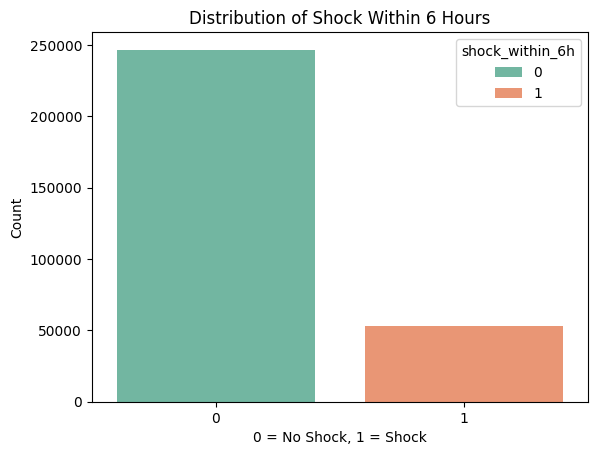

In [4]:
"""Visualizing the distribution of the target variable 'shock_within_6h' in the training dataset"""

sns.countplot(data=train, x="shock_within_6h", hue="shock_within_6h", palette="Set2")  # Create a count plot showing the number of 0s and 1s
plt.title("Distribution of Shock Within 6 Hours")  # Add a title to the plot
plt.xlabel("0 = No Shock, 1 = Shock")  # Label the x-axis
plt.ylabel("Count")  # Label the y-axis
plt.show()  # Display the plot

In [5]:
"""Checking for missing values in the training dataset and printing columns that have missing data"""

missing_counts = train.isnull().sum()  # Count the number of missing values in each column
print("Missing values per column:\n", missing_counts[missing_counts > 0])  # Print only the columns with missing values

Missing values per column:
 Series([], dtype: int64)


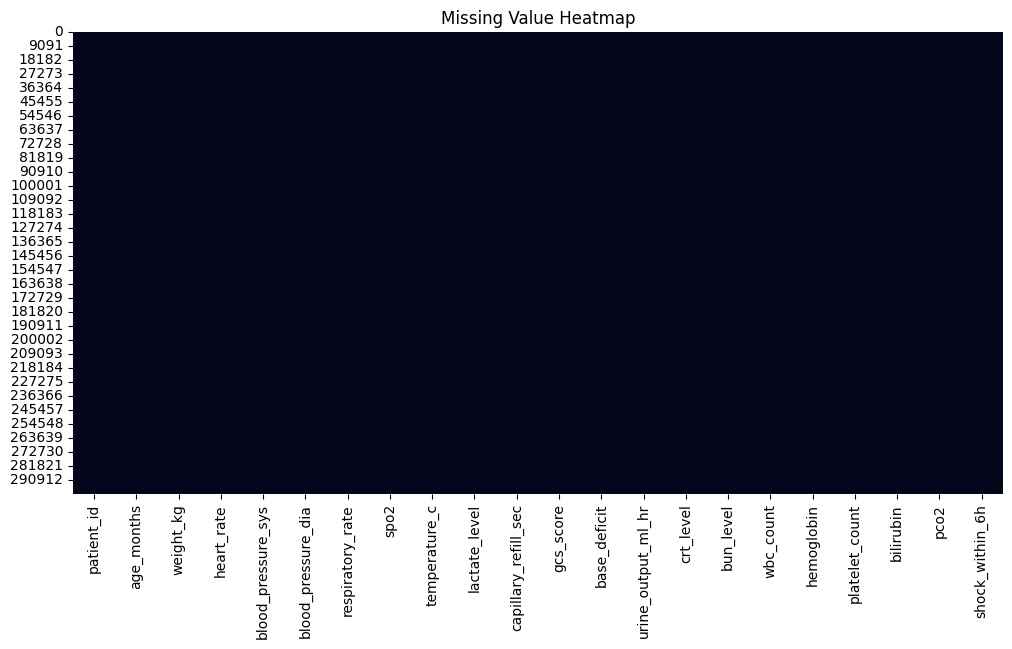

In [6]:
"""Visualizing the missing values in the training dataset using a heatmap"""

plt.figure(figsize=(12, 6))  # Set the figure size for better visibility
sns.heatmap(train.isnull(), cbar=False)  # Create a heatmap to show missing values (True = missing, False = not missing)
plt.title("Missing Value Heatmap")  # Add a title to the heatmap
plt.show()  # Display the heatmap

In [7]:
"""Preparing the feature set (X) and target variable (y) for training, and preparing the test set features"""

X = train.drop(columns=["patient_id", "shock_within_6h"])  # Drop the 'patient_id' and target column 'shock_within_6h' from the training data (features)
y = train["shock_within_6h"]  # Set the target variable 'shock_within_6h' for the training data
X_test = test.drop(columns=["patient_id"])  # Drop 'patient_id' from the test data (features), as it's not useful for prediction

In [8]:
"""Standardizing the feature sets by scaling them to have a mean of 0 and a standard deviation of 1"""

scaler = StandardScaler()  # Initialize a StandardScaler object to scale features
X_scaled = scaler.fit_transform(X)  # Fit the scaler on the training data and transform it
X_test_scaled = scaler.transform(X_test)  # Use the already fitted scaler to transform the test data

In [9]:
"""Splitting the scaled training data into training and validation sets"""

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=2025, stratify=y)  
# Split the scaled data into training (80%) and validation (20%) sets, ensuring the stratification preserves class distribution in both sets

In [10]:
"""Initializing and training an XGBoost classifier model with specified hyperparameters"""

model = xgb.XGBClassifier(
    max_depth=6,  # Maximum depth of the decision tree
    learning_rate=0.1,  # Step size for each iteration (controls overfitting)
    n_estimators=100,  # Number of boosting rounds (trees)
    subsample=0.8,  # Fraction of samples used per tree to prevent overfitting
    colsample_bytree=0.8,  # Fraction of features used per tree to prevent overfitting
    gamma=0,  # Minimum loss reduction required to make a further partition (regularization)
    reg_alpha=0,  # L1 regularization term on weights (helps with sparsity)
    reg_lambda=1,  # L2 regularization term on weights
    random_state=2025  # For reproducibility
)
model.fit(X_train, y_train)  # Fit the model to the training data

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [11]:
"""Making predictions on the validation set and evaluating model performance using F1 score and classification report"""

y_val_preds = model.predict(X_val)  # Predict the target variable for the validation set
print("Validation Macro F1 Score:", f1_score(y_val, y_val_preds, average='macro'))  # Print the F1 score (macro average) to evaluate the performance across all classes
print(classification_report(y_val, y_val_preds))  # Print a detailed classification report with precision, recall, and F1 score for each class

Validation Macro F1 Score: 0.9655185321201236
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     49345
           1       0.98      0.91      0.94     10655

    accuracy                           0.98     60000
   macro avg       0.98      0.95      0.97     60000
weighted avg       0.98      0.98      0.98     60000



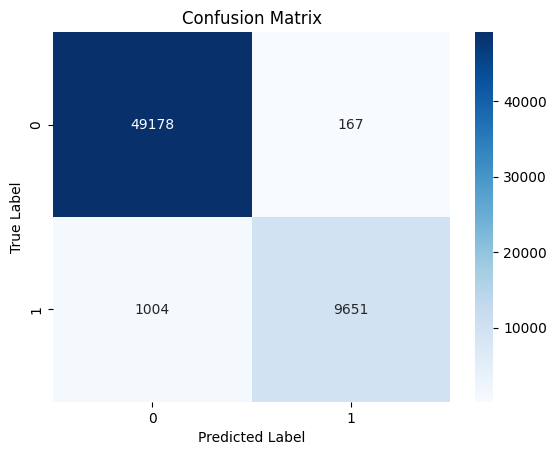

In [12]:
"""Visualizing the confusion matrix of model predictions on the validation set"""

cm = confusion_matrix(y_val, y_val_preds)  # Compute the confusion matrix for the validation set
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")  
# Plot the confusion matrix using a heatmap with annotations and integer formatting
plt.xlabel("Predicted Label")  # Label the x-axis (Predicted labels)
plt.ylabel("True Label")  # Label the y-axis (True labels)
plt.title("Confusion Matrix")  # Add a title to the heatmap
plt.show()  # Display the confusion matrix plot

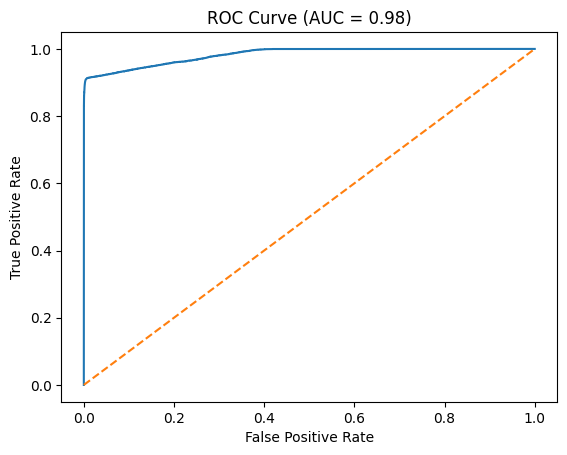

In [13]:
"""Plotting the ROC curve and calculating the AUC (Area Under the Curve) for the validation set"""

y_val_proba = model.predict_proba(X_val)[:, 1]  # Get the predicted probabilities for the positive class (class 1) from the model

fpr, tpr, _ = roc_curve(y_val, y_val_proba)  # Compute the false positive rate (fpr) and true positive rate (tpr) for the ROC curve

roc_auc = auc(fpr, tpr)  # Calculate the area under the ROC curve (AUC)

plt.plot(fpr, tpr)  # Plot the ROC curve
plt.plot([0, 1], [0, 1], linestyle='--')  # Plot a diagonal line for random classifier
plt.xlabel("False Positive Rate")  # Label the x-axis
plt.ylabel("True Positive Rate")  # Label the y-axis
plt.title(f"ROC Curve (AUC = {roc_auc:.2f})")  # Add a title with the AUC score
plt.show()  # Display the plot

In [14]:
"""Generating predictions on the test set and preparing the submission file"""

test_preds = model.predict(X_test_scaled)  # Predict the target variable for the test set

submission = sample_submission.copy()  # Make a copy of the sample submission template
submission['shock_within_6h'] = test_preds  # Insert the predictions into the 'shock_within_6h' column of the submission

submission.to_csv('submission.csv', index=False)  # Save the predictions to a CSV file without the index column
submission.head()  # Display the first few rows of the submission file

,patient_id,shock_within_6h
0,PICU_IYINNC,1
1,PICU_D7NKJF,0
2,PICU_DYGH15,0
3,PICU_RP5NBF,0
4,PICU_QJSWFK,0
